### Context

The VP of Product is interested in having a holistic view of conversion rate, especially focusing on actionable insights. What are your main findings looking at the data and what would be your top 3 product ideas to increase conversion rate? 

**Tasks**

1. What are my main findings when looking at the data in relation to conversion rate?
2. What 3 ideas would I recommend exploring further to increase the conversion rate?



### Approach
- Perform summary analysis to understand the data at a high level
- I will review numerical data to see if it makes sense to define categorical groupings, which could help make extracting insights easier
- Random Forests model to predict conversions, with the conversion being defined as the Target Variable. I will not seek to optimise the model in this exercise
- I will use 2 approaches to extract insights
    - PDP: to identify which values of variables lead to the highest conversions in relation to the base values.
    - RuleFit: to identify interesting rules/variables that could increase conversion rate


---

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pdpbox import pdp, info_plots
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from rulefit import RuleFit
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 100)
pd.set_option('display.max_colwidth', -1)
np.random.seed(4684)

In [90]:
# read exercise data into a DataFrame
data = pd.read_csv('exercise data.csv')

### Perform summary analysis to understand the data at a high level

In [91]:
data.shape

(275616, 9)

In [92]:
data.head()

,user_id,source,device,operative_system,lat,long,weekday,yearweek,converted
0,3,seo_facebook,web,mac,38.89,-94.81,Friday,16,0
1,9,seo-google,mobile,android,41.68,-72.94,Friday,18,0
2,14,friend_referral,mobile,iOS,39.74,-75.53,Saturday,13,0
3,16,ads-google,mobile,android,37.99,-121.80,Friday,21,0
4,19,ads-google,mobile,android,41.08,-81.52,Wednesday,14,0


In [93]:
# how are data in the columns distributed
data.describe(include='all')

,user_id,source,device,operative_system,lat,long,weekday,yearweek,converted
count,275616.000000,275616,275616,275616,275616.000000,275616.000000,275616,275616.000000,275616.000000
unique,NaN,12,2,6,NaN,NaN,7,NaN,NaN
top,NaN,direct_traffic,mobile,windows,NaN,NaN,Friday,NaN,NaN
freq,NaN,52594,162321,87721,NaN,NaN,80047,NaN,NaN
mean,499245.801521,NaN,NaN,NaN,37.111680,-93.981772,NaN,15.986245,0.018210
std,288533.458944,NaN,NaN,NaN,5.209627,18.086486,NaN,3.740836,0.133711
min,3.000000,NaN,NaN,NaN,19.700000,-157.800000,NaN,10.000000,0.000000
25%,249544.500000,NaN,NaN,NaN,33.660000,-112.200000,NaN,13.000000,0.000000
50%,498861.000000,NaN,NaN,NaN,37.740000,-88.930000,NaN,16.000000,0.000000
75%,748856.500000,NaN,NaN,NaN,40.700000,-78.910000,NaN,19.000000,0.000000


In [94]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275616 entries, 0 to 275615
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   user_id           275616 non-null  int64  
 1   source            275616 non-null  object 
 2   device            275616 non-null  object 
 3   operative_system  275616 non-null  object 
 4   lat               275616 non-null  float64
 5   long              275616 non-null  float64
 6   weekday           275616 non-null  object 
 7   yearweek          275616 non-null  int64  
 8   converted         275616 non-null  int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 18.9+ MB


In [95]:
# check distribution of target variable
data.converted.value_counts(normalize=True)

0    0.98179
1    0.01821
Name: converted, dtype: float64

Based on the above I cannot see any data quality issues. 

### Create PDP

1. create dummy and target variables
2. create RF model - don't optimise just create for now

Remember that all the values on a PDP are in relation to the base value for a given feature.

In [96]:
# seleect categorical variables
data_categorical = data.select_dtypes(['object']).astype("category")

# find base values
print(data_categorical.apply(lambda x: x.cat.categories[0]))

source              ads-bing
device              mobile  
operative_system    android 
weekday             Friday  
dtype: object


In [97]:
# create dummy variables
data_dummy = pd.get_dummies(data, drop_first=True)
train_cols = data_dummy.drop(columns='converted')

In [98]:
# create Decision Tree
rf = RandomForestClassifier(class_weight={0:0.05,1:0.95}, n_estimators=50)
rf.fit(train_cols, data['converted'])

RandomForestClassifier(class_weight={0: 0.05, 1: 0.95}, n_estimators=50)

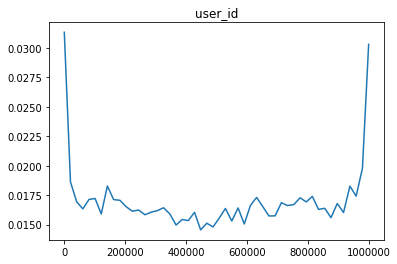

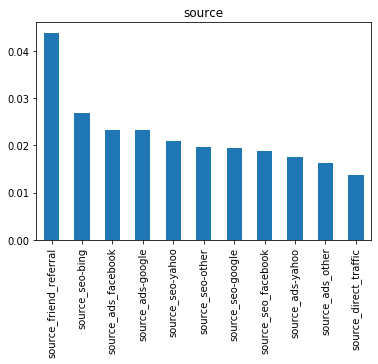

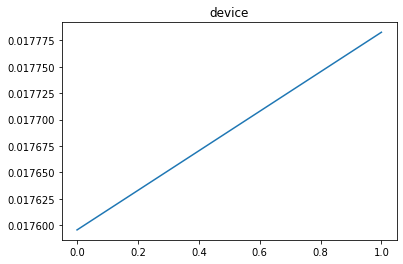

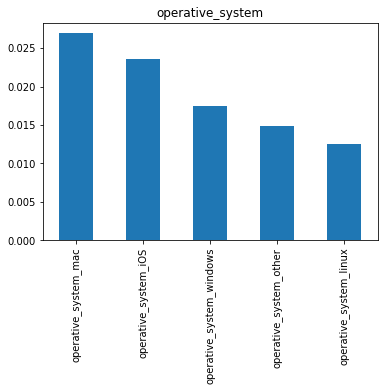

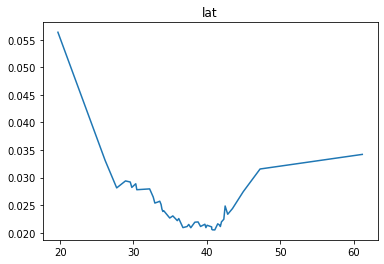

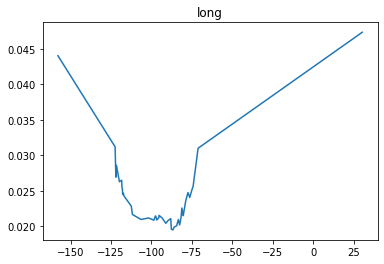

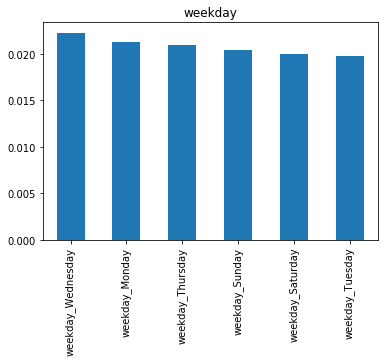

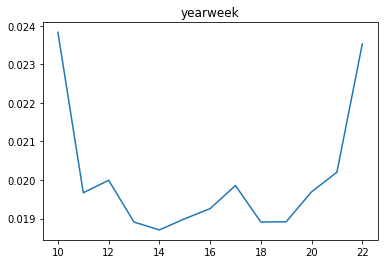

In [99]:
feat_original = data.columns.drop('converted')
  
#plot all variables with a for loop. If a variable is categorical make sure to plot all levels together.
for i in range(len(feat_original)):
    #get all variables that include the name in feat_original. So, if it is numeric, just take that variable. If it is categorical, take all dummies belonging to the same categorical variable. Since for dummies their name is variable_level, this is easy. Just pick all variables that start with the original variable name. I.e. to get all weekday dummies (weekday_Monday, weekday_Tuesday, etc.), we just look for all variables starting with "weekday"
    #variables to plot
    plot_variable = [e for e in list(train_cols) if e.startswith(feat_original[i])]
      
    #numeric variables or dummy with just 1 level
    if len(plot_variable) == 1:
       pdp_iso = pdp.pdp_isolate( model=rf, dataset=train_cols, model_features=list(train_cols), feature=plot_variable[0], num_grid_points=50)
       pdp_dataset = pd.Series(pdp_iso.pdp, index=pdp_iso.feature_grids)
       pdp_dataset.plot(title=feat_original[i])
       plt.show()
         
    #categorical variables with several levels
    else:
       pdp_iso = pdp.pdp_isolate( model=rf, dataset=train_cols, model_features=list(train_cols),  feature=plot_variable, num_grid_points=50)
       pdp_dataset = pd.Series(pdp_iso.pdp, index=pdp_iso.display_columns)
       pdp_dataset.sort_values(ascending=False).plot(kind='bar', title=feat_original[i])
       plt.show()
        
    plt.close()

#### Estimating number of users related to the results above

In [100]:
# users with lat < 28
data[data['lat'] < 28]['lat'].count()

14257

In [101]:
# users with longitude > -75 or < -125
data[(data['long'] > -75) | (data['long'] < -125)]['long'].count()

49235

In [102]:
# users who were referred by friends
data[data['source']  == 'friend_referral'].shape[0]

18011

In [103]:
# split of devices
data['device'].value_counts(normalize=True)

mobile    0.588939
web       0.411061
Name: device, dtype: float64

In [104]:
# users who visited the site at the beggining of March of end of May
data[(data['yearweek'] == 10) | (data['yearweek'] == 22)].shape[0]

42623

In [105]:
# OS split
data['operative_system'].value_counts()

windows    87721
iOS        82982
android    65305
mac        21831
other      14143
linux      3634 
Name: operative_system, dtype: int64

In [106]:
# Source split
data['source'].value_counts()

direct_traffic     52594
ads-google         51576
ads_facebook       46365
ads_other          26084
seo-google         20157
ads-bing           19887
seo_facebook       18473
friend_referral    18011
seo-other          8058 
ads-yahoo          6576 
seo-yahoo          5961 
seo-bing           1874 
Name: source, dtype: int64

#### Insights

**Base Levels**
- Base levels were:
- Source: ads-bing
- Device: mobile  
- Operative_system: android 
- Weekday: Friday  
- Month:  April 


**Findings**

- Looking at the absolute values of the y-scale, I can see that user location (lat, long) has the highest impact on the conversion. However, the absolute number of users this applies to is quite small - lat: ~5% of users (14.5K); long: 0.1% users (327). It would be interesting to see if grouping the results by city, state, the country produces any interesting insights. Perhaps there is an issue with inernational versions of the app?
- The next most important variable is the source. Specifically, users who are referred by their friends have a much higher probability of converting. 
- User_id is potentially interesting. It shows that very early and new users have a higher probability of converting. This could just be noise but is worth some further analysis to see how many users this effect actually relates to. 
- Mac and iOS have a higher probability for conversion. I wonder why this is? Are there any noticeable differences in acquisition strategies for OSes, or is the sign-up flow different? Etc... This relates to ~38% of users.
- Conversions were more likely to occur on days that were not Friday. Whatsmore, the probability of converting was slightly higher on Wednesday, Monday and Thursday.
- The yearweek variable shows spikes at the beginning and end of the period in question, which relate to ~15% of users. It would be worthing finding out what happened in these periods.
- Finally, the probability of converting was higher on the web than on mobile.


### Create RuleFit

In [107]:
# create RF model
rf = RandomForestClassifier(max_depth=2, n_estimators=20, class_weight={0:0.05,1:0.95})

In [108]:
# create RuleFit
rufi=RuleFit(rfmode="classify", tree_generator=rf, exp_rand_tree_size=False, lin_standardise=False)

rufi.fit(train_cols.values, data['converted'].values, feature_names = train_cols.columns)
print("We have extracted", rufi.transform(train_cols.values).shape[1], "rules")

We have extracted 69 rules


In [110]:
#X_concat is the new dataset given by the original variables (train_cols.values)  as well as the new rules extracted from the trees (rufi.transform(train_cols.values))
X_concat = np.concatenate((train_cols, rufi.transform(train_cols.values)), axis=1)

#Build the logistic regression with penalty.
log = LogisticRegression(penalty='l1', solver='liblinear', C=0.1)
log.fit(X_concat, data['converted'])

#get the full output with variables, coefficients, and support
output.iloc[:,2] = np.transpose(log.coef_)
output[(output['coef'] > 0.01) | (output['coef'] < -0.1)].sort_values('coef', ascending = False )
# output[output['coef'] != 0].sort_values('coef', ascending = False )

,rule,type,coef,support,importance
54,source_ads_other > 0.5 & operative_system_iOS > 0.5,rule,0.465537,0.027873,0.0
11,source_seo-google,linear,0.177454,1.000000,0.0
10,source_seo-bing,linear,0.128280,1.000000,0.0
14,source_seo_facebook,linear,0.102608,1.000000,0.0
13,source_seo-yahoo,linear,0.077551,1.000000,0.0
12,source_seo-other,linear,0.053665,1.000000,0.0
19,operative_system_other,linear,-0.127264,1.000000,0.0
35,source_ads-yahoo <= 0.5 & source_friend_referral <= 0.5,rule,-0.128019,0.911126,0.0
89,source_friend_referral <= 0.5 & source_direct_traffic <= 0.5,rule,-0.138572,0.743269,0.0
31,operative_system_iOS <= 0.5 & operative_system_other > 0.5,rule,-0.177847,0.051562,0.0


### Insights

- The are several rules relating to SEO, which if combined would have the largest +ve coeffiecient


**Questions**
- Every time I run the logistic regression I get different rules and coefficients, why is this? I would expect it to be broadly similar


### Recommendations

1. Friend referrals lead to a higer probability of conversions, what can we do in the product to encourage this further?
2. Why do users on Apple devices have higher conversion rates? Is there something different in the acquaustion strategy, sign-up flow, etc...
3. Why do users have a higher chance of converting at the beginning and end of the period? What changed in the intervening period? 
